# CIS 519 Final Project: NBA Game Win Predictor

*Group Members:* Yuqiao Xue, Yibin Zhang, Skye Wan, Ziyi You

**Project Overview**

We plan on using NBA data regarding the historic performance (from the 2003 season to the 2022 season) of teams and players across the country. We want to study to what extent the **home team advantage** leads to a win, along with the other factors corresponding to a higher win rate. For example, we predict that teams with higher steals, rebounds, and shots will win the games - our job here will be to determine to what extent these metrics correspond to win rates, and more importantly, use that to create our model to predict the winners of these home NBA games. You can access our dataset [here](https://www.kaggle.com/datasets/nathanlauga/nba-games/).

# Part 1: Data Loading and Preprocessing

We utilize a variety of imports to preprocess, perform EDA, and build our models in the project.

In [1]:
import pandas as pd
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import tqdm
import copy
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
import xgboost as xgb
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

## 1.1 Loading and Cleaning Datasets

To begin, we will load and clean two datasets: `games.csv` and `teams.csv`. These datasets contain valuable information about game results, statistics and team information, which will be essential for our analysis. By cleaning the data, we will ensure that it is in a suitable format for further exploration and modeling.

Let's proceed with loading both datasets and cleaning the games.csv dataset.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
games_df = pd.read_csv('/content/drive/My Drive/CIS 5190 Final Project/games.csv')
teams_df = pd.read_csv('/content/drive/My Drive/CIS 5190 Final Project/teams.csv')

In [4]:
games_df.describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.665100e+04,2.665100e+04,2.665100e+04,26651.000000,2.665100e+04,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,2.665100e+04,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26651.000000
mean,2.175487e+07,1.610613e+09,1.610613e+09,2012.113879,1.610613e+09,103.455898,0.460735,0.760377,0.356023,22.823441,43.374284,1.610613e+09,100.639876,0.449732,0.758816,0.349489,21.496271,42.113249,0.587032
std,5.570189e+06,8.638670e+00,8.659299e+00,5.587031,8.638670e+00,13.283370,0.056676,0.100677,0.111164,5.193308,6.625769,8.659299e+00,13.435868,0.055551,0.103429,0.109441,5.160596,6.533039,0.492376
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.143000,0.000000,4.000000,19.000000,0.000000
25%,2.070001e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.422000,0.697000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.412000,0.692000,0.278000,18.000000,38.000000,0.000000
50%,2.120076e+07,1.610613e+09,1.610613e+09,2012.000000,1.610613e+09,103.000000,0.460000,0.765000,0.357000,23.000000,43.000000,1.610613e+09,100.000000,0.449000,0.765000,0.350000,21.000000,42.000000,1.000000
75%,2.180005e+07,1.610613e+09,1.610613e+09,2017.000000,1.610613e+09,112.000000,0.500000,0.833000,0.429000,26.000000,48.000000,1.610613e+09,110.000000,0.487000,0.833000,0.419000,25.000000,46.000000,1.000000
max,5.210021e+07,1.610613e+09,1.610613e+09,2022.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.687000,1.000000,1.000000,46.000000,81.000000,1.000000


The descriptive analysis of the games.csv dataset reveals several key insights.

Notably, there's a slight home-court advantage, with home teams scoring more on average (103.46 points) compared to away teams (100.64 points), and also showing a marginal edge in assists and rebounds. Both home and away teams exhibit consistent shooting efficiencies, with field goal percentages around 46% and three-point percentages about 35-36%. Free throw performance is similar for both, averaging around 76%. Intriguingly, over 58% of the games are won by the home team, underscoring the impact of playing at home. The data, spanning from 2003 to 2022, indicates variability in team performances, reflecting the dynamic nature of basketball games.

In [5]:
#Data Types
games_df.dtypes

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object

In [6]:
#First 5 rows of data
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


**Dropping Insignificant Rows and and Null Values in games_df**
- We decided to drop the GAME_STATUS_TEXT column since it simply indicates if a game has been completed, and only has 1 value: FINAL, indicating the game status is finalized.
- We also drop the game date since the specific date is not important as we have the season.
- We also drop the TEAM_ID_home and TEAM_ID_away columns as they are duplicates

Finally, we make the column names lowercase for ease of typing.

In [7]:
games_df.drop(['GAME_STATUS_TEXT', 'GAME_DATE_EST', 'TEAM_ID_home', 'TEAM_ID_away'], axis=1, inplace=True)
games_df.columns = games_df.columns.str.lower()

We then drop rows with null values. Since all other rows are crucial to our understanding and all act as important features, we keep them.

In [8]:
games_df = games_df.dropna()

We now analyze the extreme values in the dataset - however, we realize that due to the dynamic nature of basketball. any and all scenarios are possible, and egregious situations (like no points scored) are not present in our dataset. As a result, we can keep all the values as they provide a holistic representation of the performances.

In [9]:
extreme_values = games_df.describe().loc[['min', 'max']]
extreme_values

,game_id,home_team_id,visitor_team_id,season,pts_home,fg_pct_home,ft_pct_home,fg3_pct_home,ast_home,reb_home,pts_away,fg_pct_away,ft_pct_away,fg3_pct_away,ast_away,reb_away,home_team_wins
min,10300001.0,1.610613e+09,1.610613e+09,2003.0,36.0,0.250,0.143,0.0,6.0,15.0,33.0,0.244,0.143,0.0,4.0,19.0,0.0
max,52100211.0,1.610613e+09,1.610613e+09,2022.0,168.0,0.684,1.000,1.0,50.0,72.0,168.0,0.687,1.000,1.0,46.0,81.0,1.0


### 1.1.1 Reshaping games_df

We realize that games_df currently has information about both teams in one row of data per game. To perform extensive analysis for each team, we need to reshape this data so that we have one row of data representing *statistics for each team for each game*

In [10]:
df = games_df.copy()
# Creating separate dataframes for home and away teams
home_df = df[['game_id', 'home_team_id', 'season', 'pts_home', 'fg_pct_home', 'ft_pct_home', 'fg3_pct_home', 'ast_home', 'reb_home', 'home_team_wins']].copy()
away_df = df[['game_id', 'visitor_team_id', 'season', 'pts_away', 'fg_pct_away', 'ft_pct_away', 'fg3_pct_away', 'ast_away', 'reb_away', 'home_team_wins']].copy()

# Renaming columns to be uniform
home_df.columns = ['game_id', 'team_id', 'season', 'pts', 'fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb', 'team_won']
away_df.columns = ['game_id', 'team_id', 'season', 'pts', 'fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb', 'team_won']

# Adjusting the team_won column based on whether the home team won
home_df['team_won'] = home_df['team_won'].astype(int)
away_df['team_won'] = 1 - away_df['team_won'].astype(int)

# Adding a column to identify home and visitor teams
home_df['team_type'] = 'Home'
away_df['team_type'] = 'Visitor'

# Concatenating the two dataframes
final_df = pd.concat([home_df, away_df], ignore_index=True).sort_values(by=['game_id']).reset_index(drop=True)

Representing teams by their ID is difficult. Let us introduce teams_df, which has information about each team to easily identify them by abbreviation and nickname.

In [11]:
teams_df = teams_df[['TEAM_ID', 'ABBREVIATION', 'NICKNAME']]
teams_df.columns = ['team_id', 'team_abbr', 'team_name']

We merge the two datasets on team_id

In [12]:
nba_df = final_df.merge(teams_df, on='team_id').sort_values(by=['game_id']).reset_index(drop=True)

We remove any possible nulls for good measure, and we now have a cleaned dataset to work with: **nba_df**

In [13]:
nba_df.dropna(inplace=True)
nba_df.head()

,game_id,team_id,season,pts,fg_pct,ft_pct,fg3_pct,ast,reb,team_won,team_type,team_abbr,team_name
0,10300001,1610612762,2003,90.0,0.457,0.735,0.143,23.0,41.0,1,Home,UTA,Jazz
1,10300001,1610612742,2003,85.0,0.447,0.500,0.250,20.0,38.0,0,Visitor,DAL,Mavericks
2,10300002,1610612763,2003,105.0,0.494,0.618,0.267,25.0,48.0,1,Home,MEM,Grizzlies
3,10300002,1610612749,2003,94.0,0.427,0.700,0.154,20.0,43.0,0,Visitor,MIL,Bucks
4,10300003,1610612739,2003,100.0,0.494,0.690,0.667,25.0,52.0,1,Visitor,CLE,Cavaliers


#### A note on One-Hot Encoding

We decided to one-hot encode the team_won data to make it clearer which team won, and also make our analysis on home team wins easier to comprehend.

# Part 2: Exploratory Data Analysis

After creating summary statistics and understanding the distribution, we decided to further evaluate the relationships between meaningful combinations of features.

## 2.1 Games Played over the Years

We realize that there may be more teams and games played in recent times, so we decided to utilize a scatterplot to analyze whether our data is skewed towards one end or not.

<ipython-input-14-e1241a0808d6>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


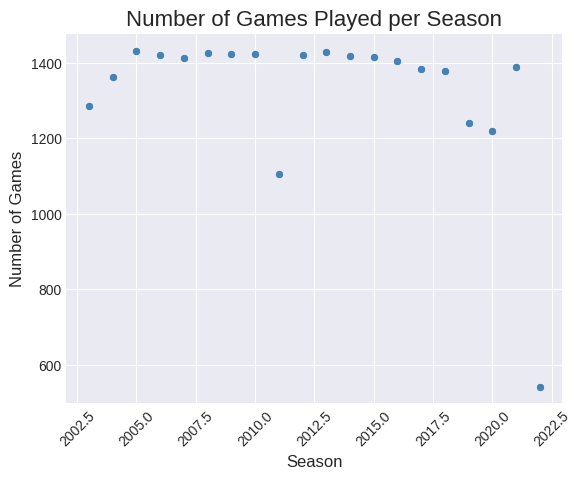

In [14]:
games_per_season = nba_df.groupby('season')['game_id'].nunique().reset_index()
plt.style.use('seaborn-darkgrid')
sns.scatterplot(data=games_per_season.reset_index(), x='season', y='game_id', color='steelblue')
plt.title('Number of Games Played per Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='both', labelsize=10)
sns.despine()
plt.show()

We notice that the games played per season is fairly standard, with a dip in the 2011 season. This is because of an NBA lockout in that season, reducing the number of games played to 66 per team. Furthermore, the 2019-2021 seasons were shortened with canceled games due to COVID-19, so that makes sense too.

The 2022-2023 season has less data since the season had not finished at the time this data was collected. Overall, our data should be fairly uniformed, with slight skews for the unnatural dips.

### 2.2 Effect of Home Court Advantage

It is widely believed that teams that play at home tend to win more. We analyze this information with the help of a visualiation to see if this correlation exists or not.

<ipython-input-16-3d43f8b50084>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=home_away_stats, x='team_type', y='team_won', palette='husl')
<ipython-input-16-3d43f8b50084>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=home_away_stats, x='team_type', y='pts', palette='husl')


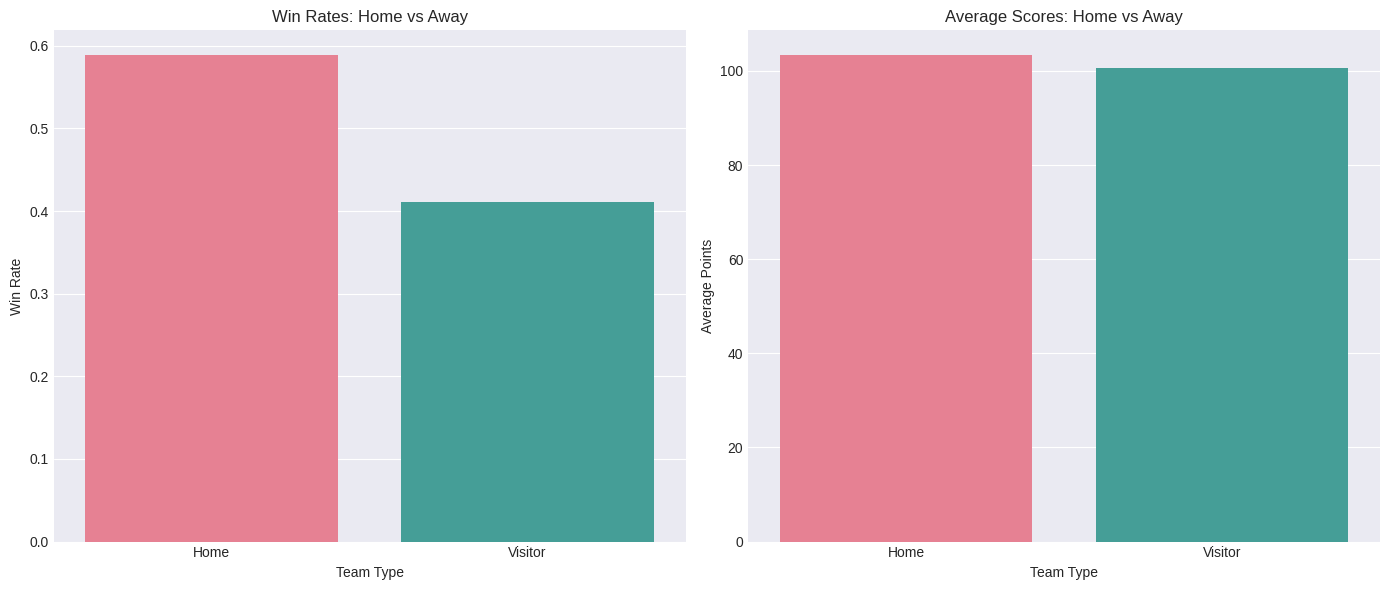

In [16]:
# Calculating the win rates and average scores for home and away games
home_away_stats = nba_df.groupby('team_type').agg({'team_won': 'mean', 'pts': 'mean'}).reset_index()

# Plotting the win rates and average scores for home and away games
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for win rates
sns.barplot(ax=axes[0], data=home_away_stats, x='team_type', y='team_won', palette='husl')
axes[0].set_title('Win Rates: Home vs Away')
axes[0].set_xlabel('Team Type')
axes[0].set_ylabel('Win Rate')

# Plot for average scores
sns.barplot(ax=axes[1], data=home_away_stats, x='team_type', y='pts', palette='husl')
axes[1].set_title('Average Scores: Home vs Away')
axes[1].set_xlabel('Team Type')
axes[1].set_ylabel('Average Points')

plt.tight_layout()
plt.show()

We notice that the home team has a serious advantage when it comes to winning games. However, the number of points they score on average is only slightly higher than the away team. Teams might not only score slightly more but also possibly concede fewer points - meaning that a strong defence might be a compelling factor to a team's win probability. Given all of these consideratons, let us shift focus to the other stats we have about the game that may contribute to winning.

## 2.3 Further Analyzing Statistics

We have a wealth of information visa-vis in game statistics. These are: \
*fg_pct*: The percentage of field goals (non-free throw goals) scored out of total number attempted \
*ft_pct*: The percentage of free throws scored out of total number attempted \
*fg3_pct*: The percentage of 3 pointer field goals scored out of total number attempted \
*ast*: The number of assists made in the game \
*reb*: The number of rebounds made in the game

We will analyze these further, and then bring a baseline for all of these statistics to work on our models.

### 2.3.1 Correlation between Features Heatmap

Over here, we analyze how our features correlate with each other to provide an insight into the intricacies that may affect the direction a game goes.

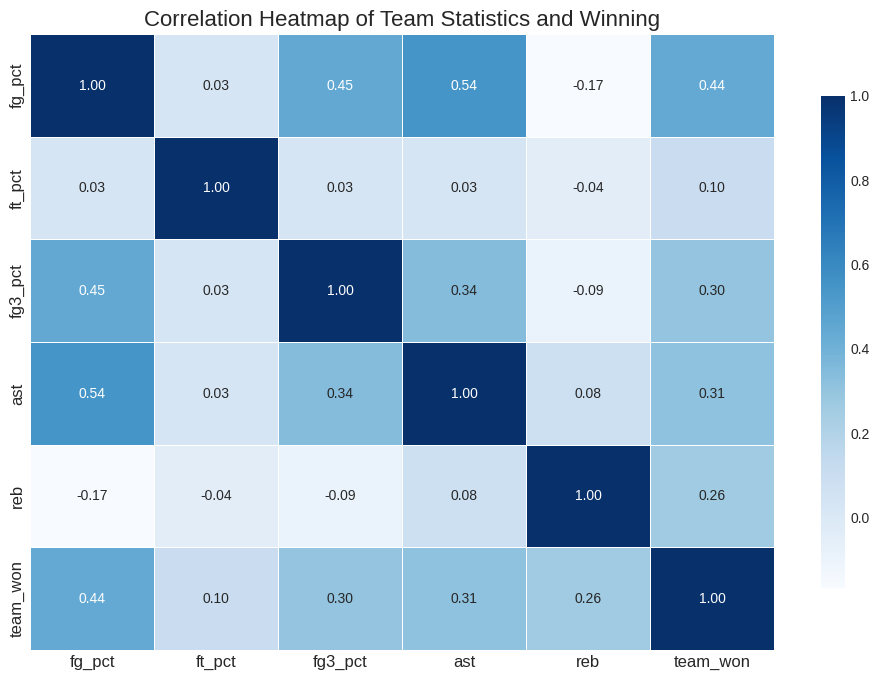

In [17]:
correlation_columns = ['fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb', 'team_won']
correlation_df = nba_df[correlation_columns]

correlation_matrix = correlation_df.corr()

#Building heatmap with Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap of Team Statistics and Winning', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The strongest correlations here are between winning a game and the field goal accuracy. \
As expected, teams that made most of their shots ended up scoring more and winning, and this consolidates our observation of a higher score for the winning teams. We also see here that there is a fairly strong correlation between rebounds and winning, meaning that a strong and proactive defence is integral to winning a game.

### 2.3.3 Comparing Average Home and Away Stats

Here we extract the columns containing both the home and away statistics that we believe attribute to a team winning. We compare the average numbers for both the home and away teams of the statistics we have been following.

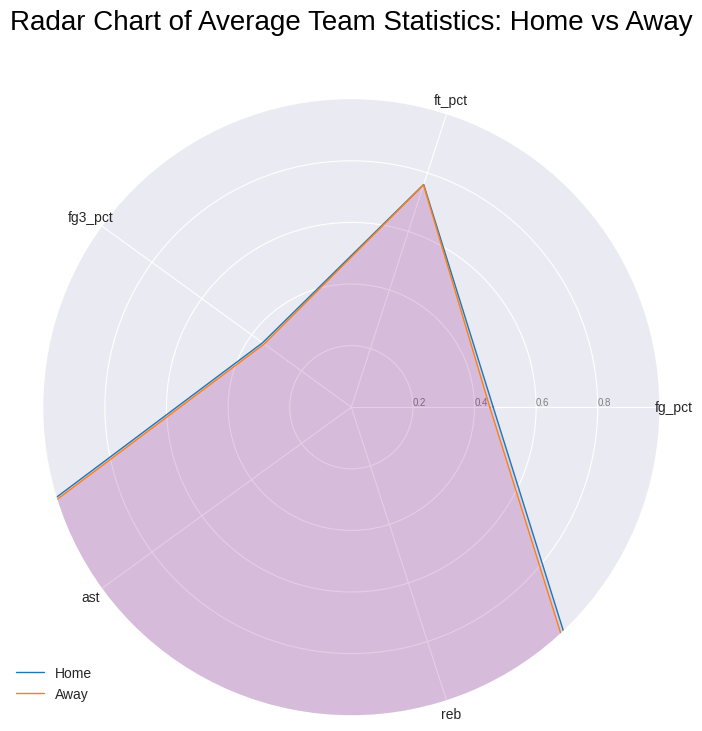

In [18]:
avg_stats_home = nba_df[nba_df['team_type'] == 'Home'][['fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb']].mean()
avg_stats_away = nba_df[nba_df['team_type'] == 'Visitor'][['fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb']].mean()

categories = list(avg_stats_home.index)
N = len(categories)

values_home = avg_stats_home.values.flatten().tolist()
values_home += values_home[:1]
values_away = avg_stats_away.values.flatten().tolist()
values_away += values_away[:1]

#angles @abhijay
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
plt.ylim(0,1)

# Plot data
ax.plot(angles, values_home, linewidth=1, linestyle='solid', label='Home')
ax.fill(angles, values_home, 'b', alpha=0.1)

ax.plot(angles, values_away, linewidth=1, linestyle='solid', label='Away')
ax.fill(angles, values_away, 'r', alpha=0.1)

plt.title('Radar Chart of Average Team Statistics: Home vs Away', size=20, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

Our analysis of the average team statistics in relation to game outcomes reveals significant insights into factors contributing to winning in basketball. \
Teams that win games tend to have higher field goal percentages, indicating efficient shooting as a key determinant of success. Additionally, winning teams generally excel in three-point shooting and demonstrate superior teamwork, as evidenced by higher assists averages. \
Interestingly, rebounds, which represent control over the ball, also play a crucial role, with winning teams outperforming in this area. While free throw percentages show less variance between winners and losers, they still contribute to the overall scoring efficiency. \
These findings suggest that focusing on shooting efficiency, effective teamwork leading to assists, and dominance in rebounding are crucial strategies for teams aiming to improve their performance and secure more wins.

**This is more easily seen using a bar chart, as below**

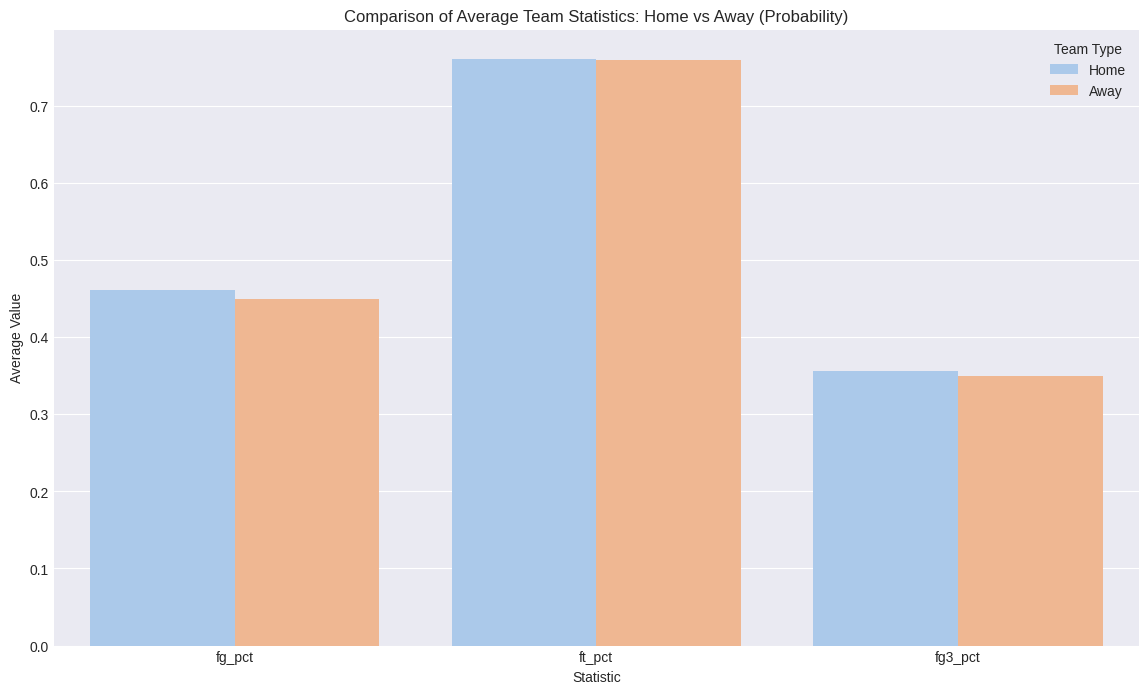

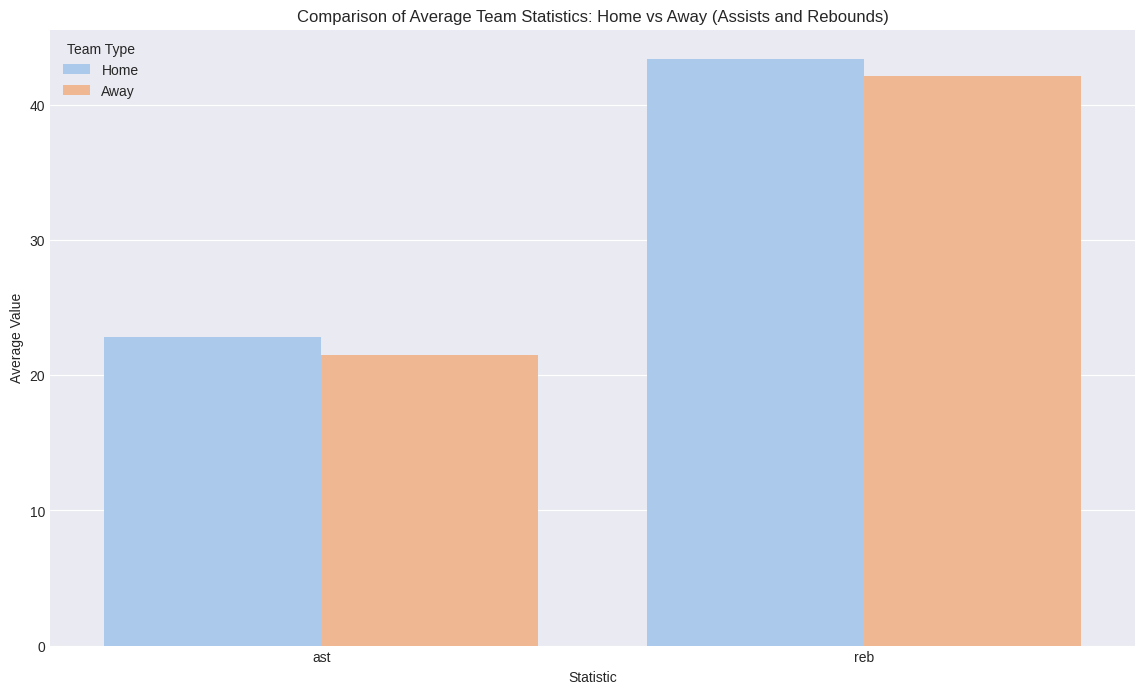

In [19]:
# Creating 2 DataFrames for visualization
avg_stats_comparison = pd.DataFrame({'Home': avg_stats_home[['fg_pct', 'ft_pct', 'fg3_pct']], 'Away': avg_stats_away[['fg_pct', 'ft_pct', 'fg3_pct']]})
astreb = pd.DataFrame({'Home': avg_stats_home[['ast', 'reb']], 'Away': avg_stats_away[['ast', 'reb']]})

avg_stats_comparison_melted = avg_stats_comparison.reset_index().melt(id_vars='index', value_vars=['Home', 'Away'])
avg_stats_comparison_melted.rename(columns={'index': 'Statistic', 'value': 'Average', 'variable': 'Team Type'}, inplace=True)

astreb_melted = astreb.reset_index().melt(id_vars='index', value_vars=['Home', 'Away'])
astreb_melted.rename(columns={'index': 'Statistic', 'value': 'Average', 'variable': 'Team Type'}, inplace=True)

# Plotting the data
plt.figure(figsize=(14, 8))
sns.barplot(x='Statistic', y='Average', hue='Team Type', data=avg_stats_comparison_melted, palette= 'pastel')
plt.title('Comparison of Average Team Statistics: Home vs Away (Probability)')
plt.xlabel('Statistic')
plt.ylabel('Average Value')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='Statistic', y='Average', hue='Team Type', data=astreb_melted, palette= 'pastel')
plt.title('Comparison of Average Team Statistics: Home vs Away (Assists and Rebounds)')
plt.xlabel('Statistic')
plt.ylabel('Average Value')
plt.show()

### 2.3.4 Winner vs Loser Statistics

We will finally look at the winner and loser statistic differences, so that we can finalize our features to perform our modeling (after some more team level analysis).

In [20]:
avg_stats_win = nba_df[nba_df['team_won'] == 1][['fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb']].mean()
avg_stats_lose = nba_df[nba_df['team_won'] == 0][['fg_pct', 'ft_pct', 'fg3_pct', 'ast', 'reb']].mean()

stats_comparison_df = pd.DataFrame({'Winner': avg_stats_win, 'Loser': avg_stats_lose})
stats_comparison_df['Difference'] = stats_comparison_df['Winner'] - stats_comparison_df['Loser']
stats_comparison_df

,Winner,Loser,Difference
fg_pct,0.480201,0.430266,0.049935
ft_pct,0.769870,0.749323,0.020547
fg3_pct,0.385550,0.319962,0.065588
ast,23.798207,20.521505,3.276702
reb,44.476537,41.010997,3.465539


## 2.4 Taking a look at the Teams

We now switch gears and look at historical team performance to visualize and see correlations between the best teams and the average statistics as a benchmark.

### 2.4.1 Baseline Statistics per Team

We start by looking at the average statistics for each team.

In [21]:
avg_stats_by_team = nba_df.groupby('team_name')[['pts', 'fg_pct', 'fg3_pct', 'ft_pct', 'reb', 'ast']].mean()
avg_stats_by_team.columns = ['Average Points', 'Average Field Goal Percentage', 'Average 3-Point Field Goal Percentage', 'Average Free Throw Percentage', 'Average Rebounds', 'Average Assists']
avg_stats_by_team.sort_values(by='Average Points', ascending=False, inplace=True)
avg_stats_by_team.reset_index(inplace=True)

#find average wins per team
average_wins_per_season = nba_df.groupby(['season', 'team_name'])['team_won'].sum().groupby('team_name').mean()
average_wins_per_season = pd.DataFrame(average_wins_per_season)

#rename team_won to Average Wins
average_wins_per_season.columns = ['Average Wins']
avg_stats_by_team = avg_stats_by_team.merge(average_wins_per_season, on='team_name')

avg_stats_by_team

,team_name,Average Points,Average Field Goal Percentage,Average 3-Point Field Goal Percentage,Average Free Throw Percentage,Average Rebounds,Average Assists,Average Wins
0,Warriors,107.508260,0.465497,0.369890,0.765214,43.301762,24.756608,51.000000
1,Suns,106.468591,0.468746,0.363344,0.772051,42.556310,23.281834,45.800000
2,Nuggets,106.207843,0.464362,0.349347,0.755067,43.731653,23.863305,49.700000
3,Rockets,103.798324,0.449920,0.352782,0.756917,43.253631,21.585475,49.800000
4,Thunder,103.783389,0.455380,0.347657,0.773767,43.957351,20.921437,46.400000
5,Lakers,103.561202,0.457132,0.343521,0.742712,43.690710,22.521311,47.350000
6,Kings,103.460674,0.456118,0.355925,0.759799,42.041396,22.026020,34.950000
7,Mavericks,103.136013,0.457464,0.357355,0.782539,42.557819,21.846916,51.850000
8,Clippers,102.833709,0.461318,0.354187,0.752239,42.625705,22.523112,45.850000
9,Raptors,102.669683,0.454393,0.356493,0.783003,41.747172,21.654412,45.550000


As seen here, it seems that the Warriors are the highest performing team on average when it comes to point scoring. We will see if this is a big impact when it comes to win rates.

### 2.4.2 Biggest Winners

We now look at the teams who have won the most over time. Although there may be inconsistencies over time, with different performances in different seasons, these teams are clearly most dominant overall, and could show us a new correlation between winning and our various features.

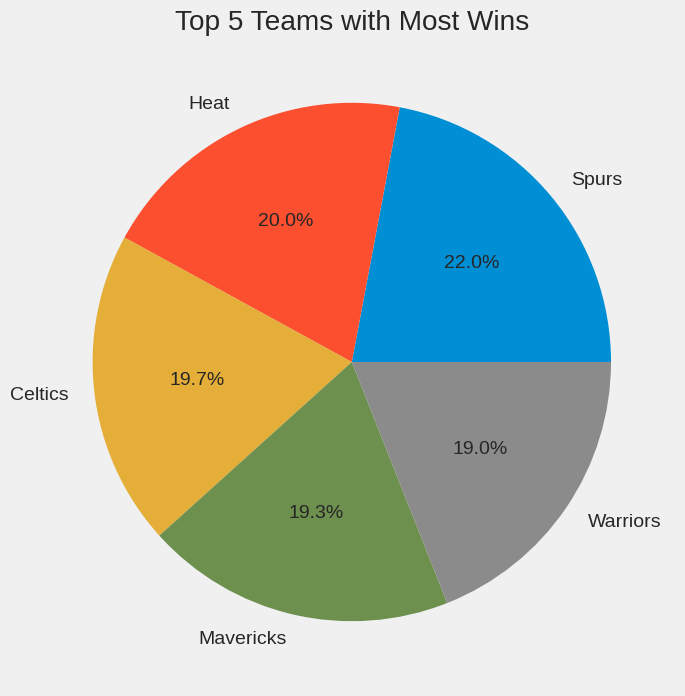

In [22]:
plt.style.use('fivethirtyeight')

# Recreating the pie chart with the new background style
team_wins = nba_df[nba_df['team_won'] == 1].groupby('team_name')['team_won'].count().sort_values(ascending=False)
top_5_teams_wins = team_wins.head(5)

plt.figure(figsize=(10, 8))
top_5_teams_wins.plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 5 Teams with Most Wins')
plt.ylabel('')  # Hiding the y-label
plt.show()

# Reverting to the default style for future plots
plt.style.use('default')

In [23]:
# Calculating the percentage of games won by each team over the seasons
team_wins_percentage = nba_df.groupby(['season', 'team_name'])['team_won'].mean().reset_index()

# Finding the top 5 teams based on overall win percentage
overall_team_wins_percentage = team_wins_percentage.groupby('team_name')['team_won'].mean().sort_values(ascending=False)
top_5_teams = overall_team_wins_percentage.head(5).index

# Filtering the data for only the top 5 teams
top_5_teams_trends = team_wins_percentage[team_wins_percentage['team_name'].isin(top_5_teams)]

# Plotting the trends in % of games won for the top 5 teams
fig = px.line(top_5_teams_trends, x='season', y='team_won', color='team_name',
              title='Win Percentage Trend of Top 5 Teams Over Seasons',
              labels={'team_won': 'Win Percentage', 'season': 'Season', 'team_name': 'Team Name'})

# Customizing the layout
fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Win Percentage',
    legend_title='Team Name',
    xaxis=dict(tickmode='linear'),
    plot_bgcolor='white',
    font=dict(size=12)
)

# Show the plot
fig.show()

In the chart, the line representing the *San Antonio Spurs* appears to be the most consistent. It shows the least variability in win percentage over time compared to the other teams. The Spurs' line remains relatively flat, especially in comparison to teams like the Celtics and Nuggets, which have more pronounced peaks and troughs.

While other teams exhibit periods of high success or steep declines, the Spurs' line suggests a stable level of performance, indicating consistent success across the seasons depicted. However, the Spurs are not in the top 5 (or 10) average point scorers, further exemplifying our hypothesis that defence and other factors are also important when it comes to winning games.

## 2.5 Addressing Collinearity

We realize that there might be issues with collinearity with our data. Over here, we will analyze where we may have collinearity between features, and then use the insights to perform the right analysis in our modeling stages. We will use the Variance Inflation Factor (VIF) metric to analyze which features are most collinear, and we can then make sound decisions on how to combat this to end up with a successful analysis. The higher the VIF number, the more collinear the feature is.

In [24]:
vif_data = pd.DataFrame()
vif_data["feature"] = correlation_df.columns
vif_data["VIF"] = [variance_inflation_factor(correlation_df.values, i) for i in range(correlation_df.shape[1])]
vif_data

,feature,VIF
0,fg_pct,71.892949
1,ft_pct,40.894565
2,fg3_pct,14.492445
3,ast,28.293959
4,reb,29.112046
5,team_won,2.344833


We notice some extremely interesting insights here. First is that we have a lot of collinear data here - primarily field goals and points have extremely high VIF, meaning they are very collinear. This makes sense, as more field goals scored means there are more points scored, and more points scored results in more games being won. As a result, in our modeling, we will first deal with these issues and choose features appropriately.

### EDA Conclusion

We have computed, observed, and analyzed several values and come to the realization that the features we examined more closely relate to the outcome and performance of a team. Therefore, we will be using the analyses we averaged out to deterine the number of wins a team has in a season in our model. As a reminder, our findings were that:

*The winner averages: **4.99%** better field goal accuracy, **2.05%** better free throw accuracy, **6.56%** better 3-point accuracy. The winner also averages **3.27** more assists and **3.47** more rebounds a game.*

# Part 3: Feature Engineering and Modeling
This part focus on predicting outcomes of NBA games.
The objective is to analyze historical game statistics and leverage different machine learning models
 to predict whether the home team wins or loses. We will start with a baseline model and future iterations will explore more complex models and techniques for enhanced predictive performance.

## 3.1 Features and Model Selection

We start off by preparing our data for modeling by performing some feature selection. We will create and train a baseline model. This model is simple yet effective for binary classification tasks, from which we can build on more complex models.

### 3.1.1 Data Preparation and Feature Selection

We engineer relevant features for our model. We're focusing on basic game statistics such as points, assists, rebounds, and shooting percentages for both home and away teams. We also engineer the home_team_wins column to further optimize our analysis. We also add the mean of the values to fill in any missing data that may have slipped through, but we have ensured that the data is free of any of these issues in previous sections.


In [25]:
nba_df['diff_pts'] = nba_df.groupby('pts')['fg_pct'].diff().fillna(0)
nba_df['diff_fg_pct'] = nba_df.groupby('game_id')['fg_pct'].diff().fillna(0)
nba_df['diff_ft_pct'] = nba_df.groupby('game_id')['ft_pct'].diff().fillna(0)
nba_df['diff_fg3_pct'] = nba_df.groupby('game_id')['fg3_pct'].diff().fillna(0)
nba_df['diff_ast'] = nba_df.groupby('game_id')['ast'].diff().fillna(0)
nba_df['diff_reb'] = nba_df.groupby('game_id')['reb'].diff().fillna(0)

X = nba_df[['diff_pts', 'diff_fg_pct', 'diff_ft_pct', 'diff_fg3_pct', 'diff_ast', 'diff_reb']]
nba_df['home_team_wins'] = (nba_df['team_won'] == 1) & (nba_df['team_type'] == 'Home')
nba_df['home_team_wins'] = nba_df['home_team_wins'].astype(int)
y = nba_df['home_team_wins'] # target variable

X = X.copy()
X.fillna(X.mean(), inplace=True)

### 3.1.2 PCA

We use the highly conventional 80/20 split for train and test data, as well as the seed value of 42 to mimic the pseudo randomness from homeworks. We will do a PCA to understand the structure of our data. This will help us not only in feature selection but also in more complex models we perform. We have to ensure that we scale the features using StandardScaler() before conducting the PCA as this is crucial to having accurate results by revealing the most influential features in the dataset.

In [49]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training set
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_train_initial_fit = pca.fit(X_train_scaled)

In [51]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)

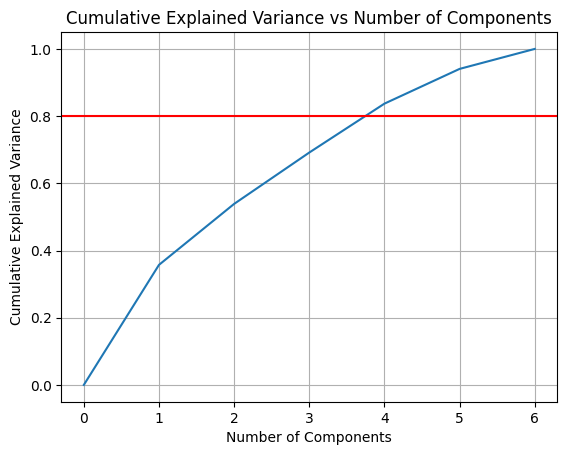

In [52]:
# Plotting the explained variance vs number of components plot
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1))
plt.grid()
plt.show()

From this plot, it's clear that the optimal number of components is 4. As we seek to choose the minimum number of components that corresponds to our explained variance threshold, we should choose 4 as it is the intersection point of our 80% explained variance threshold and the explained variance corresponding to each number of components. With that complete, we now have our data that has been normalized. In addition, the input data has also been made independent.

In [53]:
X_test_scaled = scaler.transform(X_test)
pca_final = PCA(n_components = 4)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

### 3.1.3 SMOTE: Addressing Imbalance

We noticed from our baseline log-reg that our data has the potential to suffer from a low recall and F-1 score for predicting wins. Our logistic regression already did a (fairly) good job of predicting losses, but the class imbalance that we have in our data could be the reason our model was suffering when it comes to predicting wins.

After not seeing much success in our more complex models, we decided to utilize SMOTE (Synthetic Minority Oversampling Technique) which is used to replicate data and assist with upsampling. This balances our classes for wins and losses and would allow us to obtain better F1 and recall scores, even if it may be at the slight expense of accuracy. Let us now proceed with this context with preparing our data and looking at various models.

You can learn more about SMOTE [here](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c#:~:text=Synthetic%20Minority%20Over%2Dsampling%20TEchnique%2C%20or%20SMOTE%20for%20short%2C,class%20imbalance%20in%20a%20dataset.):

In [54]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

We can now use X_train_smote, y_train_smote in our models.

### 3.1.4 Decision Tree with SMOTE Evaluation
After training, scaling, and dimension reducing, we evaluate our baseline model's performance on the test dataset. We use accuracy as a primary metric and provide a detailed classification report for a more nuanced understanding of the model's performance in predicting home team wins and losses.

In [68]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test_pca = scaler.transform(X_test_pca)

# Define a decision tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the decision tree model with SMOTE data
decision_tree.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_tree = decision_tree.predict(X_test_pca)

# Evaluate the decision tree model
accuracy_tree = accuracy_score(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree)

print(f"Decision Tree Model with SMOTE Accuracy: {accuracy_tree:.3f}")
print(f"Classification Report:\n{report_tree}")

Decision Tree Model with SMOTE Accuracy: 0.558
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.66      7456
           1       0.32      0.42      0.36      3165

    accuracy                           0.56     10621
   macro avg       0.52      0.52      0.51     10621
weighted avg       0.60      0.56      0.57     10621



### Decision Tree Model Conclusion

In this segment of the project, we successfully prepared our dataset, selected pertinent features, and trained a baseline decision tree model with SMOTE to address class imbalance. The model's performance was evaluated using accuracy and a detailed classification report, providing insight into its predictive capabilities in determining the outcomes of NBA games (win/loss for the home team). It had an overall accuracy of approximately 55%, this result may change every time after running due to the randomness in the SMOTE algorithm.

The model performs better in predicting home team losses (class 0) than wins (class 1), as indicated by higher precision, recall, and F1-score for class 0.  After applying SMOTE, the model is now somewhat better at identifying actual wins compared to before.

The weighted average precision, recall, and F1-scores are reasonably balanced, indicating a moderate performance. The use of SMOTE has helped the model handle the class imbalance better, particularly improving the recall and F1-score for the minority class (home team wins).

This baseline decision tree model with SMOTE provides a foundation for comparison with subsequent, more complex models. The performance of the decision tree highlights areas for improvement, particularly in better handling the imbalance in the dataset and improving the prediction of home team wins.

## 3.2 Ridge Regression


Given that we have already conducted a PCA, and due to the collinearity in our data, even after excluding the field goal feature, we are left with a lot of potential to overfit data. As a result, we will perform a Ridge Regression which will allow us to minimize the impact of less important features. We set alpha as 0.5.

In [62]:
ridge_model = RidgeClassifier(alpha=0.5)
# ridge_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_ridge = ridge_model.predict(X_test_pca)

# Evaluating the model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
report_ridge = classification_report(y_test, y_pred_ridge)

print(f"Ridge Model Accuracy: {accuracy_ridge:.2f}\n\nClassification Report:\n{report_ridge}")

Ridge Model Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      7456
           1       0.53      0.42      0.47      3165

    accuracy                           0.71     10621
   macro avg       0.65      0.63      0.64     10621
weighted avg       0.70      0.71      0.70     10621



Our ridge model performs better than our baseline model. Let us perform hyperparameter tuning to find the best parameters to see if we can boost the performance.

In [63]:
alpha_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

ridge_classifier = GridSearchCV(RidgeClassifier(), {'alpha': alpha_range}, scoring='accuracy', cv=5)

ridge_classifier.fit(X_train_smote, y_train_smote)

# Best alpha value
print("Best alpha value:", ridge_classifier.best_params_['alpha'])

# Use the best model for predictions
best_ridge_model = ridge_classifier.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_pca)

# Evaluating the model with the best alpha
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
report_ridge = classification_report(y_test, y_pred_ridge)

print(f"Ridge Model (Best Alpha) Accuracy: {accuracy_ridge:.2f}\n\nClassification Report:\n{report_ridge}")

Best alpha value: 100
Ridge Model (Best Alpha) Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      7456
           1       0.53      0.42      0.47      3165

    accuracy                           0.71     10621
   macro avg       0.65      0.63      0.64     10621
weighted avg       0.70      0.71      0.70     10621



There seems to be no real change here. This could be since our data is quite regularized due to the competitive nature of basketball, where minor differences in statistics have a larger impact on the game - something our model here cannot quite capture. However, we can continue exploring with the help of more complex models.

## 3.3 XGBoost

XGBoost might be useful to identify the improvements over the decision tree baseline, mainly because XGBoost can handle a larger amount of data and is generally more resistant to overfitting. It also opens up the door to more interpretable models.

As a result, we decided to implement it with some hyperparameter tuning to analyze any potential improvements. The best parameters found were: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}.

In [36]:
# Parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Create the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized Search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=25, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)

# Fit the model
random_search.fit(X_train_smote, y_train_smote)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred_xgb = best_model.predict(X_test_pca)

# Evaluate the model
print("XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Best parameters found:  {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost Model Accuracy: 0.6399585726391112
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.65      0.72      7456
           1       0.43      0.61      0.50      3165

    accuracy                           0.64     10621
   macro avg       0.61      0.63      0.61     10621
weighted avg       0.69      0.64      0.65     10621



The XGBoost model achieved an accuracy of approximately 64%, showing some improvement over the baseline decision tree model, which had an accuracy of 55.1%. Interestingly, the XGBoost model demonstrated better precision for predicting losses but struggled with predicting wins. Despite these improvements, the model did not perform as well as we hoped in some areas. With these results, we will move on to exploring different types of models that can better handle our varied and nuanced data, and address potential overfitting issues.

## 3.4 Random Forest

For our NBA game prediction task, we now choose to analyze our data with a Random Forest because it excels in handling classification problems with complex and varied data, much like our diverse NBA statistics. Its ability to work with many input variables makes it well-suited for analyzing the intricate patterns in player and team performances. Random Forest also manages the potential overfitting issue we are facing here. By averaging out decisions, we can potentially receive some more insights from our data. By including our SMOTE data here, we are able to ensure our data is as clean dimensionally, it is balanced, and has a powerful model to predict on. We will use a matrix to see any improvements here.

In [55]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
over_X, over_y = smote.fit_resample(X_train_pca, y_train)

# Build SMOTE Random Forest model
SMOTE_RF = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Evaluate SMOTE RF model with less extensive cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

Mean precision: 0.661
Mean recall: 0.688
Mean f1: 0.674
Accuracy: 0.634


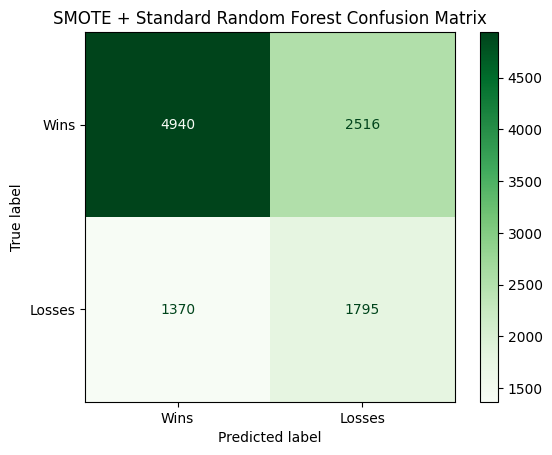

In [56]:
scoring_metrics = ['f1', 'precision', 'recall']
scores = cross_validate(SMOTE_RF, over_X, over_y, scoring=scoring_metrics, cv=cv)

print('Mean precision: %.3f' % np.mean(scores['test_precision']))
print('Mean recall: %.3f' % np.mean(scores['test_recall']))
print('Mean f1: %.3f' % np.mean(scores['test_f1']))

# Train SMOTE RF
SMOTE_RF.fit(over_X, over_y)

# SMOTE RF prediction result
y_pred = SMOTE_RF.predict(X_test_pca)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % accuracy)

# Create confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Wins', 'Losses'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

Despite our expectations, the Random Forest model with SMOTE only achieved a mean accuracy of 63.4%. While this represents some improvement over the baseline decision tree model, it falls short of the performance we observed with other models like XGBoost and Ridge Regression. Further investigation and more advanced modeling techniques may be necessary to better capture the nuances in the data.

### 3.4.1 Random Forest with Hyperparameter Tuning

We will now conduct hyperparameter tuning to see if we can improve the performance of this Random Forest Model.

**We have run the GridSearchCV and determined the best parameters to use are {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}**

In [57]:
best_params = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

# Creating the Random Forest model with the best parameters
rf_model = RandomForestClassifier(random_state=42,
                                  max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  min_samples_split=best_params['min_samples_split'],
                                  n_estimators=best_params['n_estimators'])

# Fitting the model to the training data
rf_model.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test_pca)

# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

In [61]:
print(f"Random Forest Model Accuracy: {(accuracy_rf):.3f}\n")

Random Forest Model Accuracy: 0.662



It seems like tuning our parameters has led to a small increase in accuracy. This shows us that implementing a Random Forest with hyperparameter tuning is indeed performing better than our baseline model, but it is not the best.

## 3.5 Deep Learning

As a final effort, we will employ some deep learning models to our dataset, in the hopes of finding better accuracy. We will use a simple feedforward neural network using TensorFlow and Keras. This will help us delve into the complexity of our dataset, and address our biggest issues of nuances, collinearity, overfitting, and perform some valid regularization.

### 3.5.1 Deep Learning Imports

We wanted to explore libraries and see if something would pop up! As a result, we first ran on 5 epochs, and saw some promising results, so increased it.

In [60]:
model = Sequential([
    # Input layer with dimensionality of the input features
    Dense(128, activation='relu', input_shape=(X_train_smote.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    # Additional hidden layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    # Output layer with binary classification (0 or 1)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train_smote, y_train_smote, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 64)               

As seen here, the deep learning model achieved an accuracy of 73%, which is better than the Random Forest model, similar to the performances of XGBoost and Ridge Regression, and is also a significant improvement over the baseline decision tree model.

Note that we experimented with different numbers of epochs but they all resulted in a similar accuracy. Furthermore, we experimented with fewer and greater hidden layers but they once again produced similar results. We hypothesize this may simply be a result of the fact that there is insufficent training data for the neural network to fully capture the nuances and complexities that may exist, otherwise the deep learning model should perform much better.

## 4 Conclusion

**In summary, here are the main takeaways:**

We were able to learn a lot about class imbalance and using new techniques such as SMOTE, which ended up fixing a lot of our problems. It turns out, sometimes the issues are the way we understand the data, rather than the complexity of the data. We were also able to understand just how much of an impact collinearity has, and the various methods to limit the effect of this.

Although we were able to engineer some interesting features, there is definitely potential to add more features to increase the complexity of the dataset. This would have helped us with our more complex models, such as the feedforward neural net.

The best model was the Deep Learning model which boosted our accuracy significantly. Although we had hoped we could achieve better accuracy values with our other models, we are unfortunately limited by the complexity and size of the dataset we chose to use. This sparse dataset was truly a struggle at times to work with.

**In the future, it would be interesting to consider implementing the following modifications:**

Joining with more datasets to increase the complexity of the model.

Experimenting more with neural networks and seeing if implementing different activation functions or optimizers would help improve the efficacy of the model in fitting the test data.

Looking into how stadium size, supporter age, and other external factors affected a teams home performance.